# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.isna().sum() # находим количество пропусков в каждом из признаков датасета

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# приводим признак balance к корректному виду
df.balance = df.balance.replace({',00': '', ' ': '', '\$': ''}, regex=True).astype('float') # исключаем все лишние символы и приводим к типу float
df.balance.describe() # выводим статистику обработанного признака

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

In [6]:
df = df.fillna({'balance': df.balance.median()}) # заменяем пропуски на медианное значение признака
df.balance.describe() # выводим статистику обработанного признака

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 5

In [7]:
# заменяем неявные пропуски значением NaN
df.replace({'job': {'unknown': np.nan}, 
            'education': {'unknown': np.nan}}, inplace=True)
# заменяем пропуски в признаках job и education модальными значениями
df.fillna({'job': df.job.mode()[0], 
            'education': df.education.mode()[0]}, inplace=True)

In [8]:
print('popular education:', df['education'].value_counts().index[0]) # находим самый распространённый уровень образования
print('popular job:', df['job'].value_counts().index[0]) # находим самую популярную работу
# далее расчитываем средний баланс клиентов в зависимости от работы и уровня образования
df.pivot_table(columns='job', index='education', values='balance', aggfunc='mean') 

popular education: secondary
popular job: management


job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,
primary,775.928571,1304.818444,1314.707317,1366.444444,1841.534247,2222.631769,1254.928571,1383.554217,1492.047619,1805.975610,1607.392857
secondary,1189.494662,1125.866889,1304.445161,1018.229885,1598.882979,2594.966759,1373.517007,1028.724269,1333.574219,1461.055511,1147.082949
tertiary,1343.482143,1730.062500,2090.189394,2069.162791,1826.104710,2314.992857,2254.047826,1279.754717,2018.722892,1766.792706,1552.666667


### Задание 6

In [9]:
quartile_1, quartile_3 = df.balance.quantile(0.25), df.balance.quantile(0.75) # находим 25-ый и 75-ый квантиль
lower_bound = quartile_1 - ((quartile_3 - quartile_1) * 1.5) # находим нижнюю границу значений
upper_bound = quartile_3 + ((quartile_3 - quartile_1) * 1.5) # находим верхнюю границу значений
outliers = df[(df.balance < lower_bound) | (df.balance > upper_bound)] # находим выбросы в признаке balance
df = df.drop(outliers.index, axis=0) # удаляем выбросы из данных
df.shape[0] # количество оставшихся данных

10105

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


''

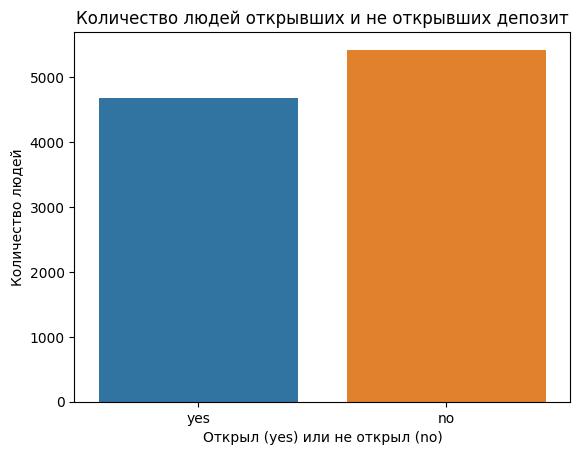

In [10]:
print(df['deposit'].value_counts()) # распределение целевого признака
# построение столбчатой диаграммы признака deposit
sns.countplot(x=df['deposit'])
plt.title('Количество людей открывших и не открывших депозит') # подпись к графику
plt.xlabel('Открыл (yes) или не открыл (no)') # подпись к оси x
plt.ylabel('Количество людей') # подпись к оси y
;

* Дисбаланс классов незначителен.

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


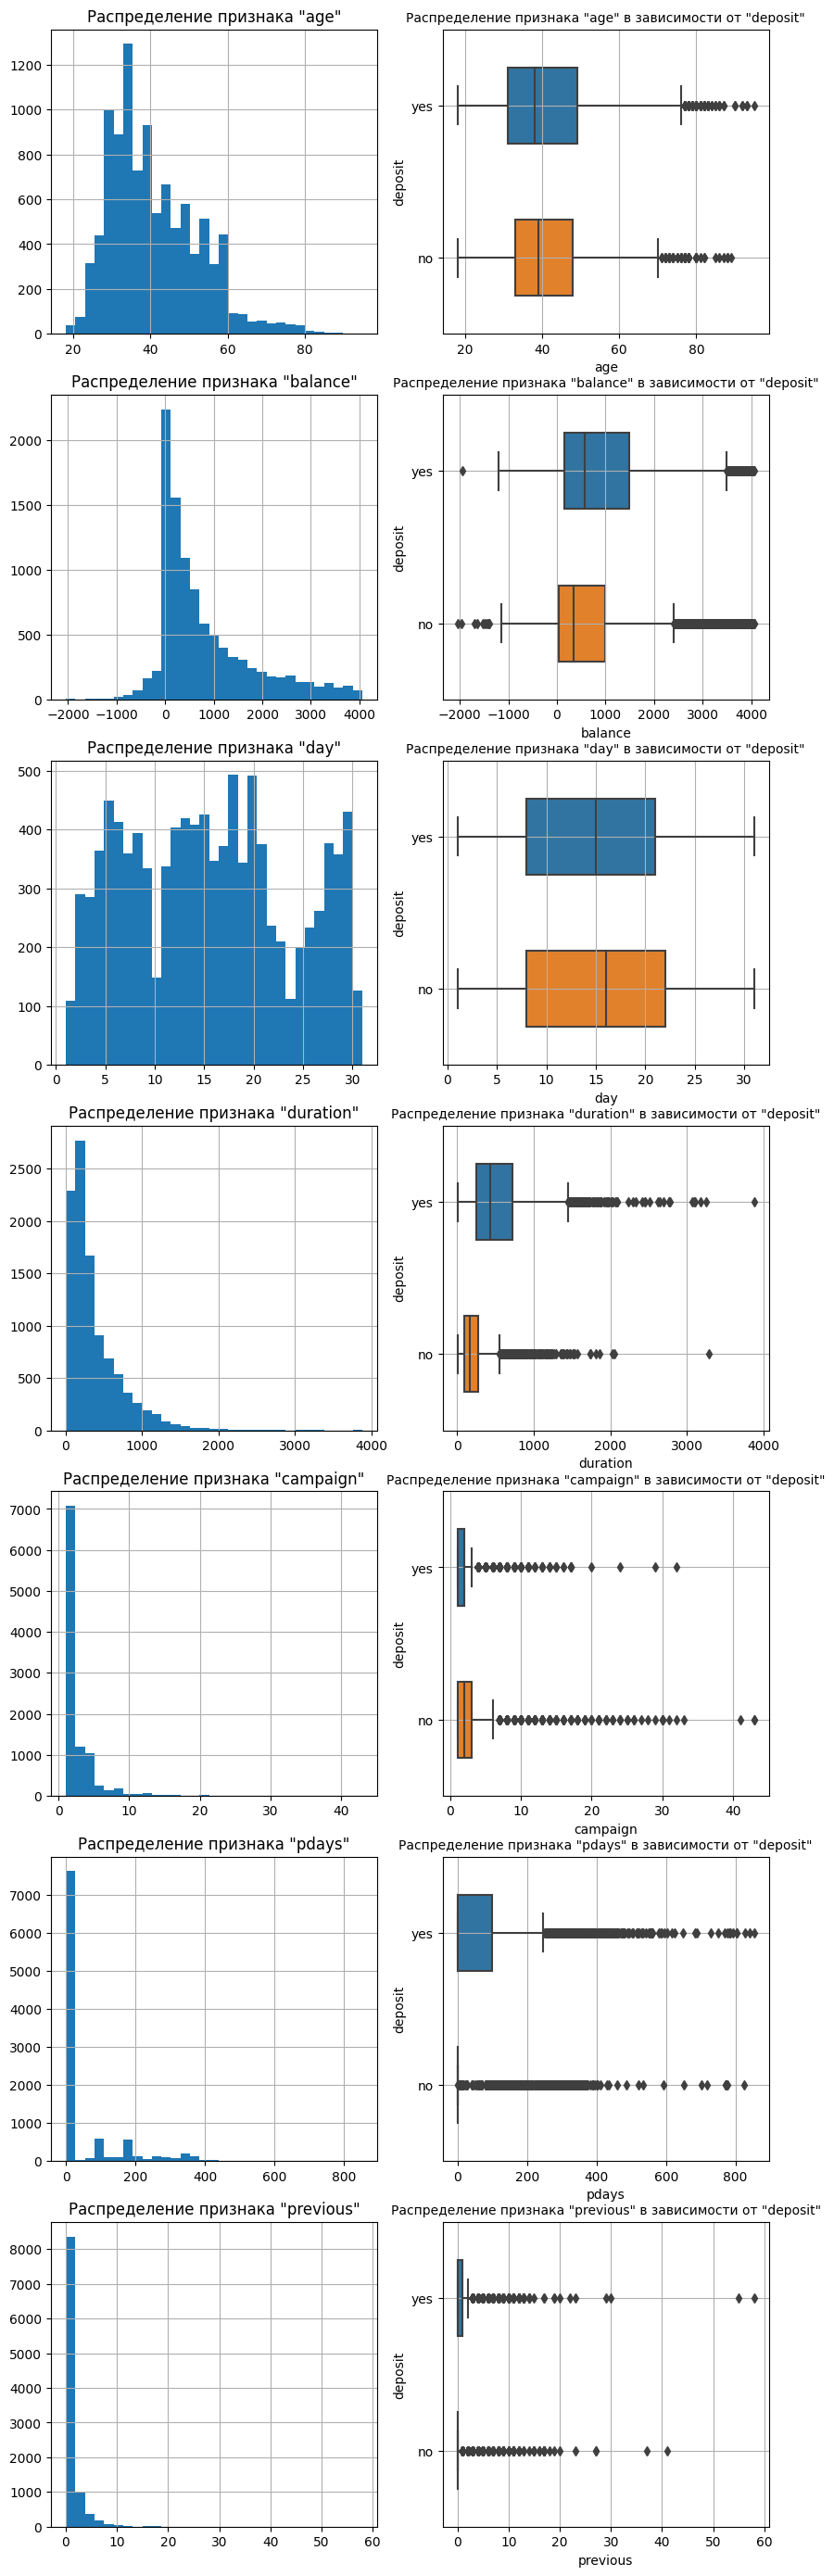

In [11]:
quantitative_features = df.select_dtypes(['int', 'float']).columns # выделяем названия количественных признаков в датасете
display(df[quantitative_features].describe()) # выводим статистику по количественным признакам
# построим графики по каждому из количественных признаков
fig, ax = plt.subplots(7, 2, figsize=(10, 35))
for num, i in enumerate(quantitative_features):
    ax[num, 0].hist(df[i], bins=31) # создаём гистограмму
    ax[num, 0].grid() # добавляем сетку
    ax[num, 0].set_title(f'Распределение признака "{i}"') # подпись к графику
# дополнительно построим коробчатые диаграммы в разрезе целевого признака "deposit"
for num, i in enumerate(quantitative_features):
    sns.boxplot(x=df[i], y=df['deposit'], ax=ax[num, 1], width=0.5) # создаём коробчатую диаграмму
    ax[num, 1].grid() # добавляем сетку
    ax[num, 1].set_title(f'Распределение признака "{i}" в зависимости от "deposit"', fontdict = {'fontsize' : 10}) # подпись к графику

* Признаки ***duration***, ***campaign***, ***pdays***, ***previous*** явно содержат выбросы.
* Возраст большей части клиентов находится в пределах от 20 до 40 лет.
* Баланс значительной доли клиентов близок к нулю.

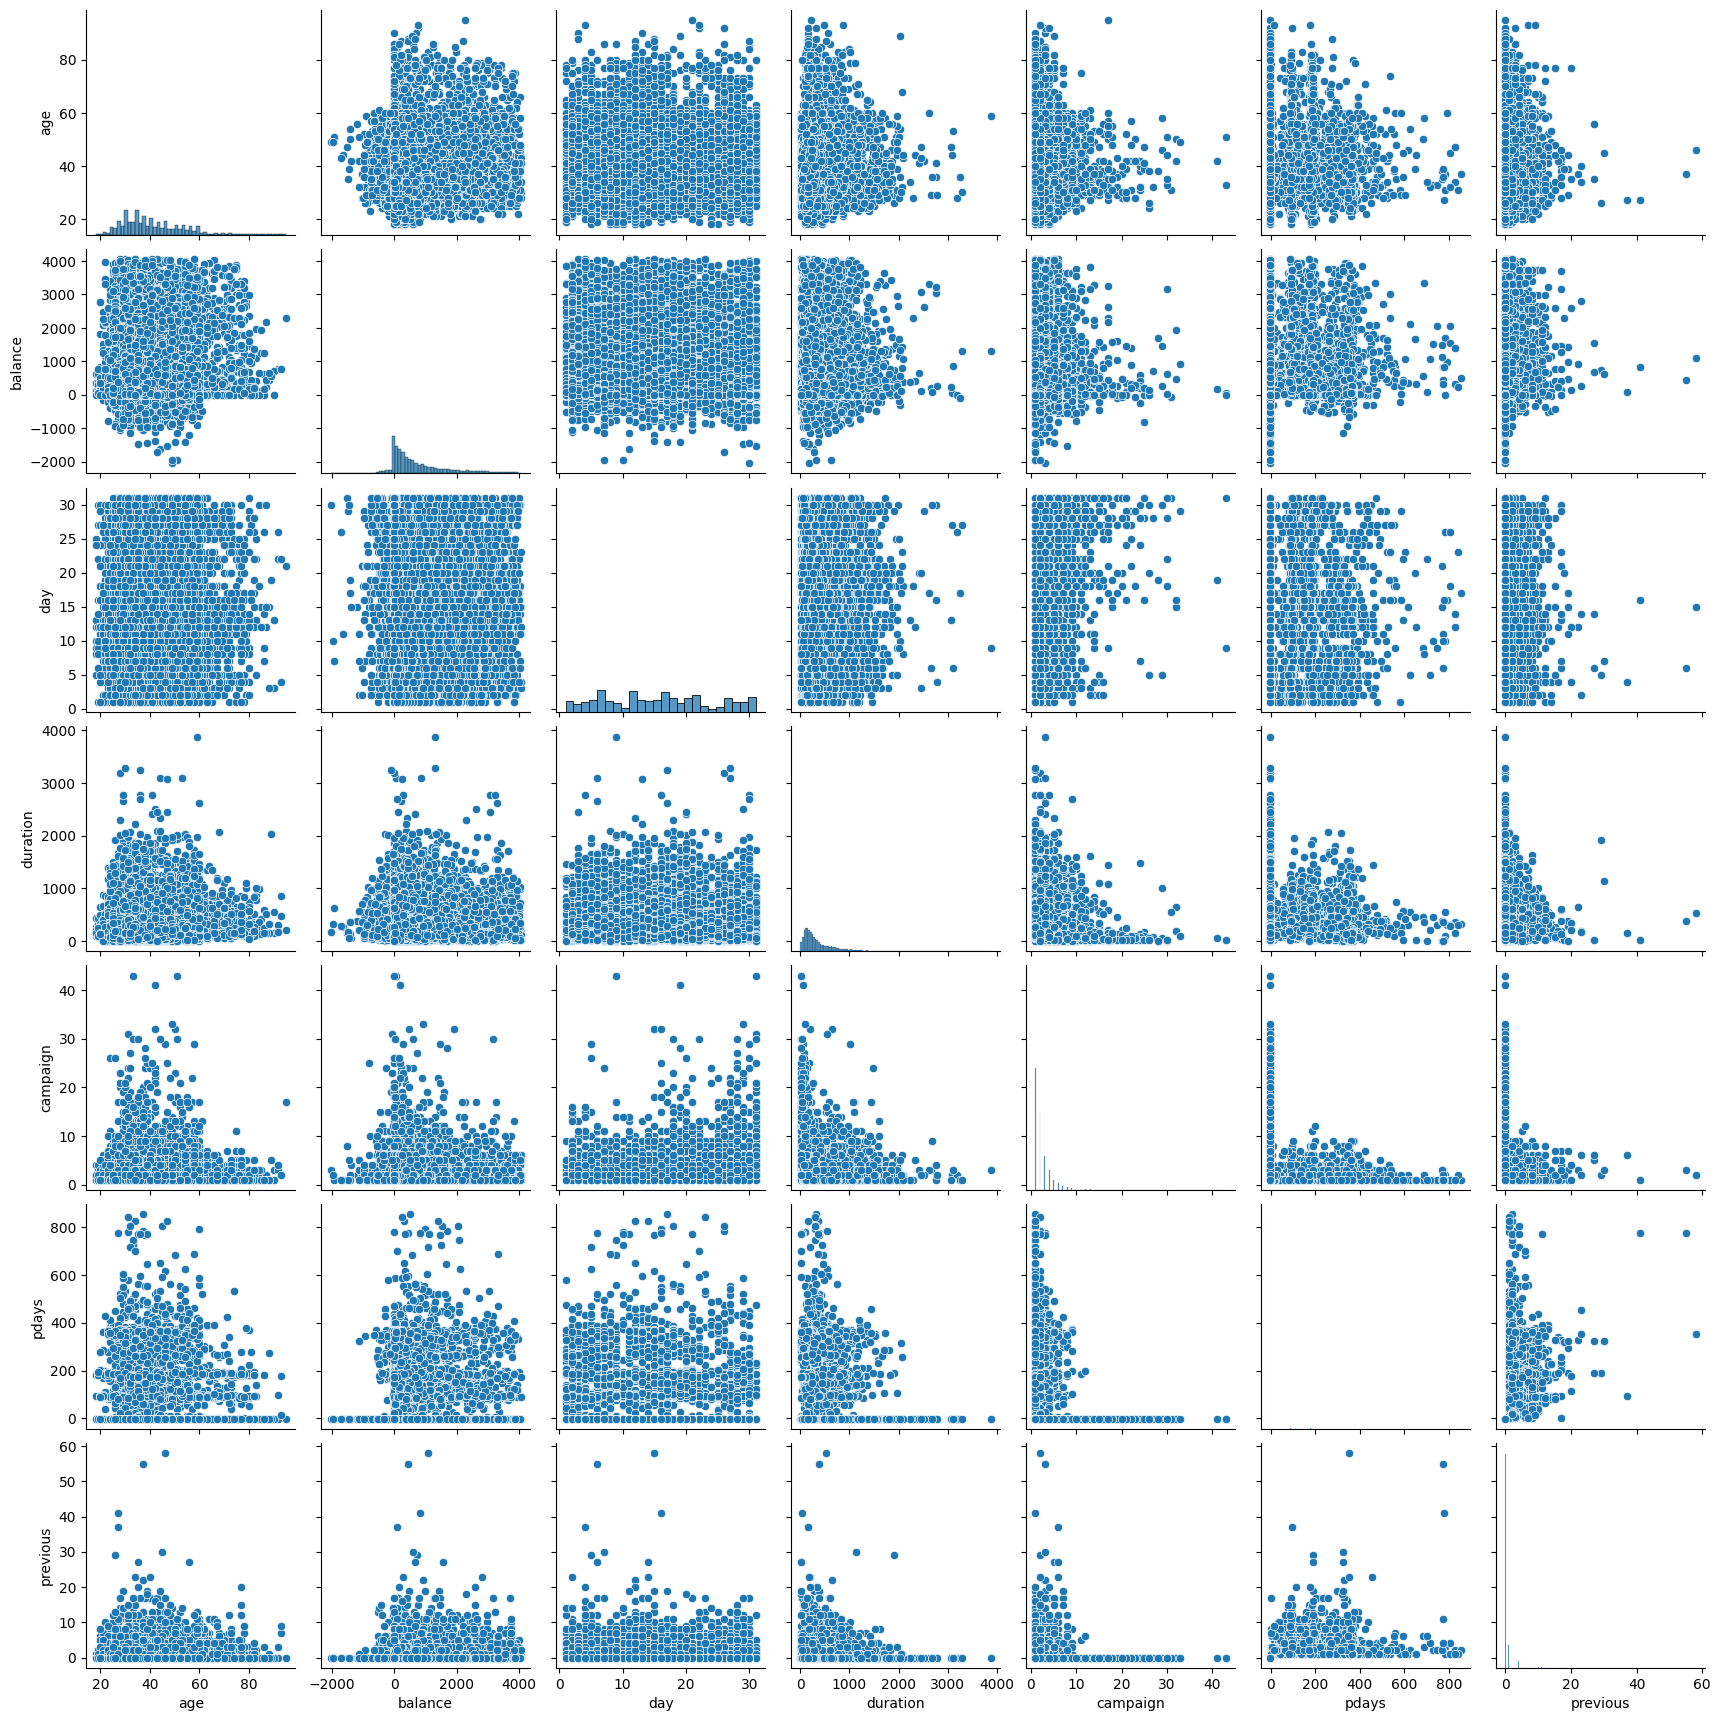

In [12]:
# выводим зависимости каждого признака по отношению к другим признакам
sns.pairplot(df[quantitative_features]);

* Признак дня последнего контакта с клиентом не имеет явной связи с другими признаками, за исключением количества этих контактов в текущей маркетинговой компании.
* Нет явной зависимости и между признаком баланса и возрастом клиента. Можно лишь отметить, что после 60 лет, отрицательные значения баланса отсутствуют.

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


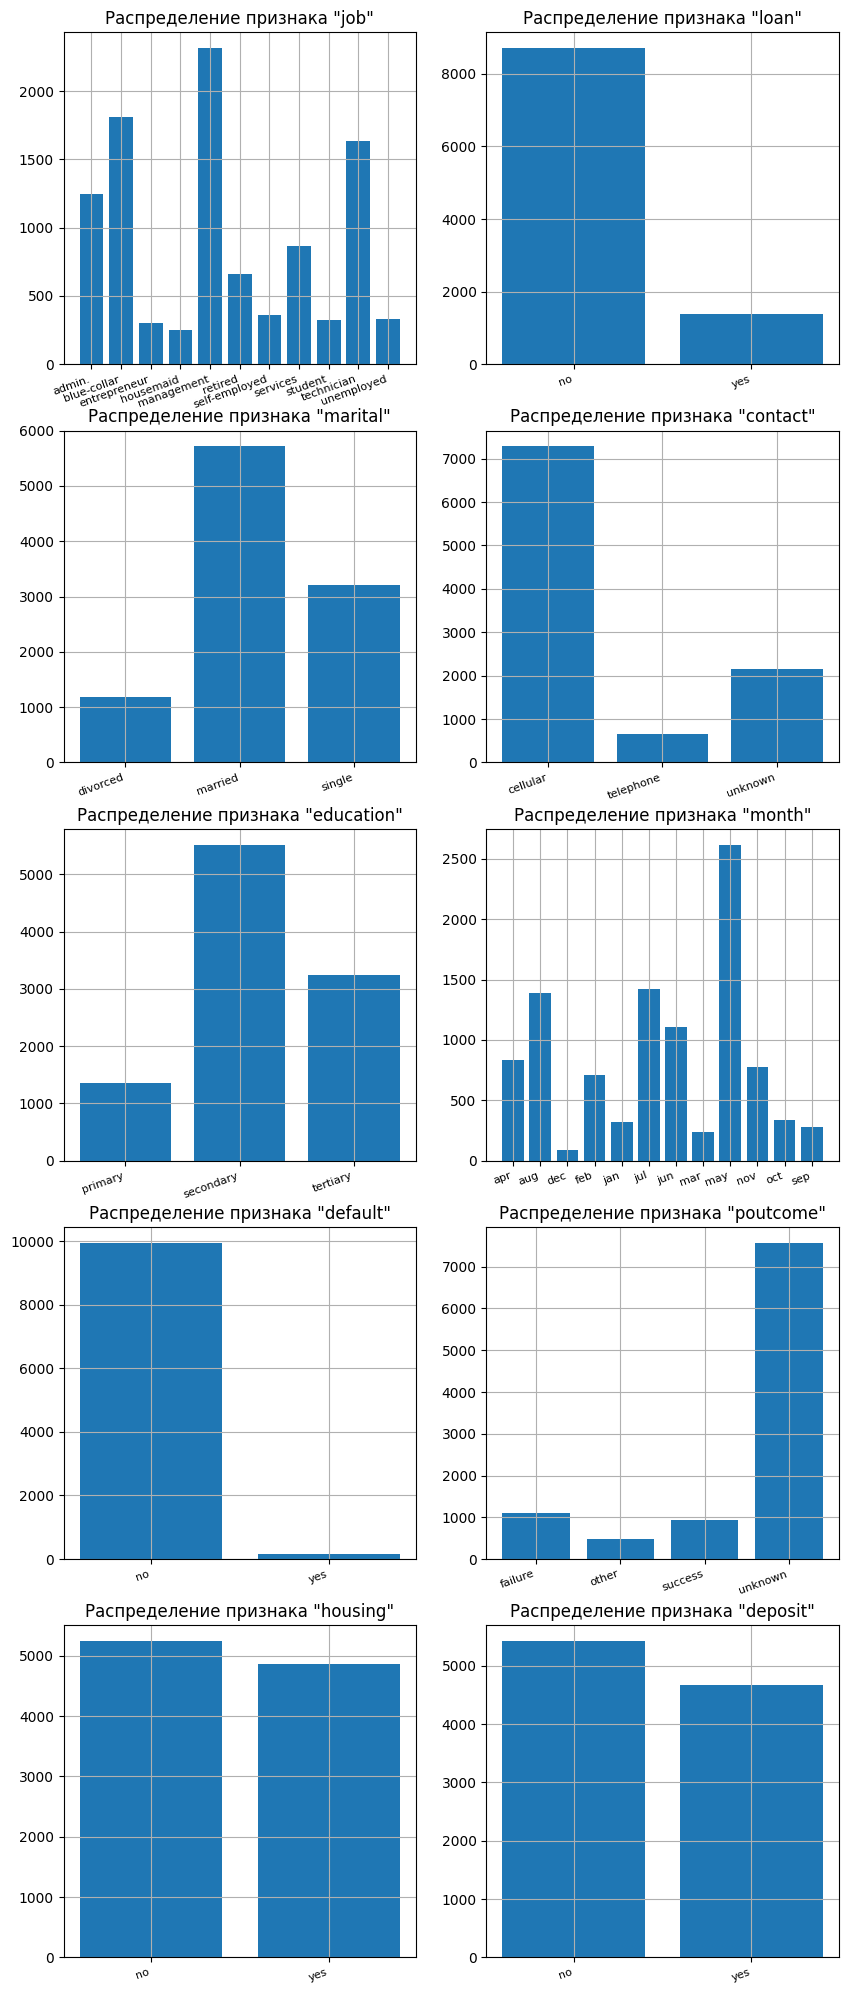

In [13]:
categorical_features = df.select_dtypes('object').columns # выделяем названия категориальных признаков в датасете
display(df[categorical_features].describe()) # выводим статистику по категориальным признакам
# построим графики по каждому из категориальных признаков
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
for num, i in enumerate(categorical_features):
    col=0
    if num >= 5: # после пяти графиков, последующие переходят во второй столец
        num -= 5
        col=1
    ax[num, col].bar(df.groupby(i)['age'].count().index, df.groupby(i)['age'].count().values) # создаём столбчатую диаграмму
    # далее добавляем наклон, изменяем размер и выравниваем метки оси x
    ax[num, col].set_xticklabels(ax[num, col].get_xticklabels(), rotation=20, horizontalalignment='right', x=1.0, fontsize=8) 
    ax[num, col].grid() # добавляем сетку
    ax[num, col].set_title(f'Распределение признака "{i}"') # подпись к графику

* Самая популярная область деятельности среди клиентов - это менеджмент, семейное положение - женат, образование - среднее, тип контакта с клиентом - по сотовой связи, месяц - май, а результат прошлой маркетинговой кампании - неизвестно.
* Лишь у минимального числа клиентов кредит просрочен.
* Почти у половины клиентов имеется кредит на жильё.
* Далеко не многие берут кредит на личные нужды.

### Задание 6

In [14]:
print(df[(df['poutcome']=='failure') | (df['poutcome']=='success')]['deposit'].value_counts(normalize=True)) 
print(df['deposit'].value_counts(normalize=True)) # результаты текущей компании

yes    0.685492
no     0.314508
Name: deposit, dtype: float64
no     0.536764
yes    0.463236
Name: deposit, dtype: float64


### Задание 7

Text(0, 0.5, 'Количество результатов')

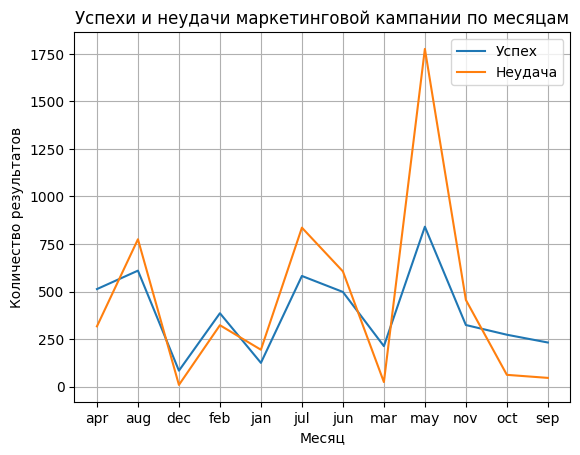

In [15]:
# количество успехов маркетинговой компании в зависимости от месяца
success_line = df.replace({'deposit': {'yes': 1, 'no': 0}}).groupby('month')['deposit'].sum() 
plt.plot(success_line) # построение графика
# количество неудач маркетинговой компании в зависимости от месяца
plt.plot(df.replace({'deposit': {'yes': 1, 'no': 0}}).groupby('month')['deposit'].count() - success_line) # добавление линии неудач
plt.legend(['Успех', 'Неудача']) # добавление легенды
plt.grid() # сетка
plt.title('Успехи и неудачи маркетинговой кампании по месяцам') # заголовок
plt.xlabel('Месяц') # подпись к оси x
plt.ylabel('Количество результатов') # подпись к оси y

### Задание 8

In [16]:
# создаём функцию, разделяющую признак age по возрастным группам
def get_age_group(value): 
    if value < 30:
        return '<30'
    elif value >= 30 and value < 40:
        return '30-40'
    elif value >= 40 and value < 50:
        return '40-50'
    elif value >= 50 and value < 60:
        return '50-60'
    elif value >= 30:
        return '60+'
age_groups_data = df['age'].apply(get_age_group) # применяем функцию
# создаём функцию строящую диаграмму зависимости признака deposit от указанного категориального признака
def deposit_category_plot(data, cat_feature, x_label, title, rotation=0, horizontalalignment='center'):
    # строим столбчатую диаграмму
    fig, ax = plt.subplots()
    # делим данные в зависимости от определённого признака
    grouped_data =  data.groupby(cat_feature)['deposit'].value_counts()
    x = np.arange(len(grouped_data.loc[:, 'yes'].index))
    ax.bar(x - 0.15, width=0.3, # задаём смещение столбцов левее, а также их ширину
        height=grouped_data.loc[:, 'yes']) # успехи маркетинговой кампании
    ax.bar(x + 0.15, width=0.3, # задаём смещение столбцов правее, а также их ширину
        height=grouped_data.loc[:, 'no']) # неудачи маркетинговой кампании
    ax.set_xticks(x)
    ax.set_xticklabels(grouped_data.loc[:, 'yes'].index, rotation=rotation, horizontalalignment=horizontalalignment) # заменяем метки оси x
    ax.legend(['Успех', 'Неудача']) # задаём легенду
    ax.grid() # сетка
    ax.set_title(title) # заголовок
    ax.set_xlabel(x_label) # подпись к оси x
    ax.set_ylabel('Количество результатов') # подпись к оси y

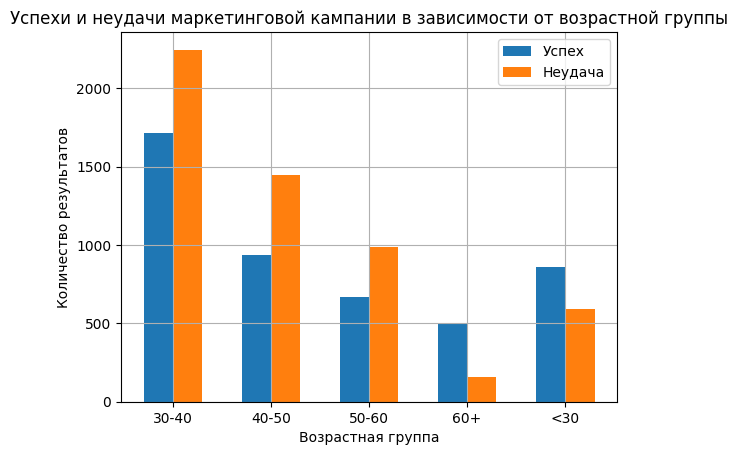

In [17]:
deposit_category_plot(df, age_groups_data, 'Возрастная группа', 'Успехи и неудачи маркетинговой кампании в зависимости от возрастной группы');

### Задания 9 и 10

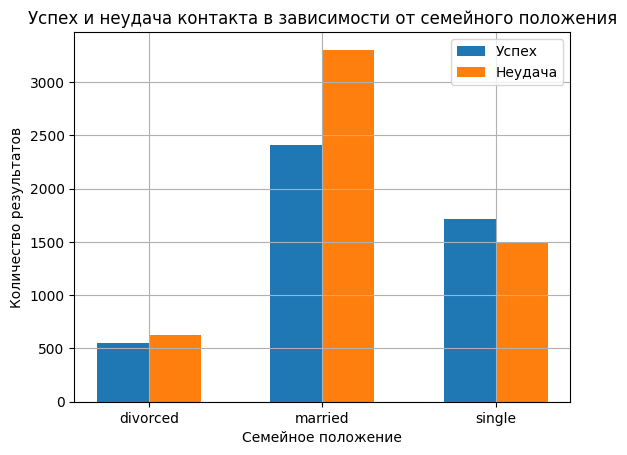

In [18]:
deposit_category_plot(df, 'marital', 'Семейное положение', 'Успех и неудача контакта в зависимости от семейного положения');

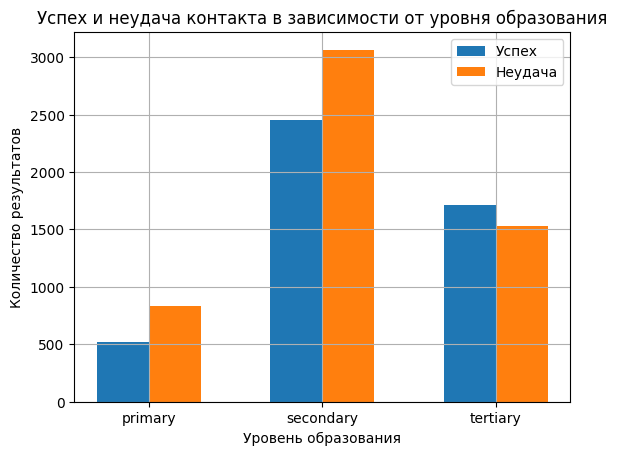

In [19]:
deposit_category_plot(df, 'education', 'Уровень образования', 'Успех и неудача контакта в зависимости от уровня образования');

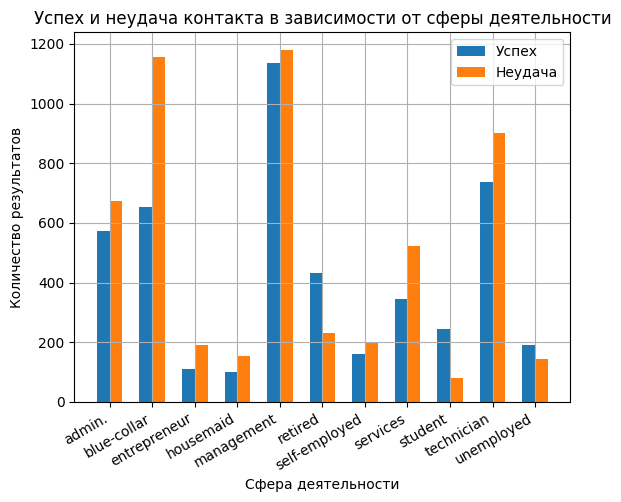

In [20]:
deposit_category_plot(df, 'job', 'Сфера деятельности', 'Успех и неудача контакта в зависимости от сферы деятельности', 30, 'right')

### Задание 11

''

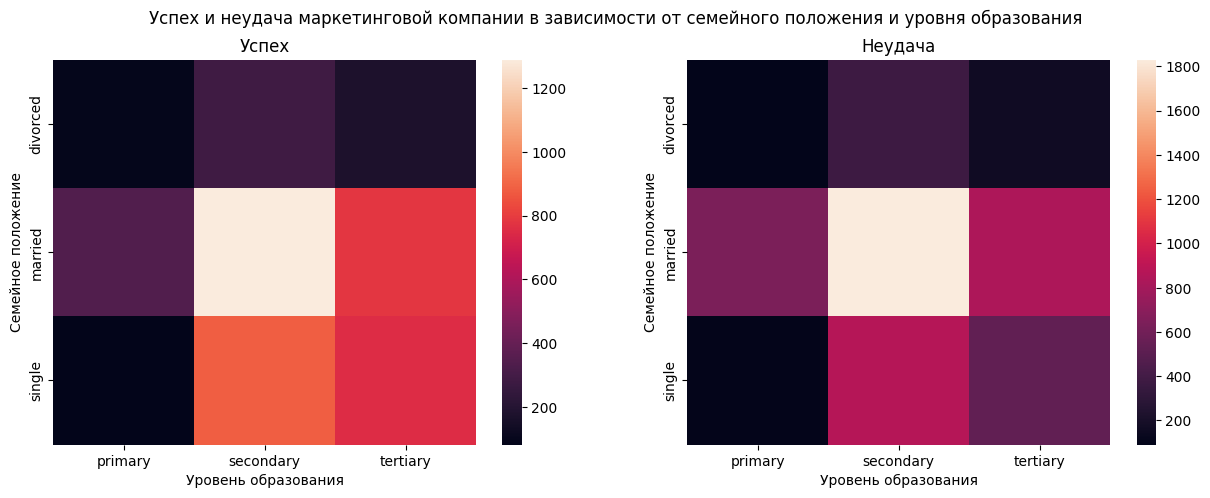

In [21]:
# создаём сводную талицу по пересечению семейного полежения и уровня образования
crossing_data_yes = df[df['deposit']=='yes'].pivot_table(values='deposit', index='marital', columns='education', aggfunc='count')
crossing_data_no = df[df['deposit']=='no'].pivot_table(values='deposit', index='marital', columns='education', aggfunc='count')
# строим тепловые карты по полученным сводным таблицам 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1) 
sns.heatmap(crossing_data_yes) # построение тепловой карты
plt.title('Успех') # заголовок
plt.xlabel('Уровень образования') # подпись к оси x
plt.ylabel('Семейное положение') # подпись к оси y
plt.subplot(1, 2, 2) 
sns.heatmap(crossing_data_no) # построение тепловой карты
plt.title('Неудача') # заголовок
plt.xlabel('Уровень образования') # подпись к оси x
plt.ylabel('Семейное положение') # подпись к оси y
plt.suptitle('Успех и неудача маркетинговой компании в зависимости от семейного положения и уровня образования') # общий заголовок
;

## Часть 3: преобразование данных

### Задание 1

In [22]:
encoder = preprocessing.LabelEncoder() # создаём кодировщик порядковых признаков
df['education'] = encoder.fit_transform(df['education']) # преобразуем признак education
print(df['education'].sum())
df['age'] = encoder.fit_transform(age_groups_data) # преобразуем признак age
print(df['age'].sum())

11995
13469


### Задания 2 и 3

In [23]:
df.replace({'deposit': {'yes': 1, 'no': 0}}, inplace=True) # кодируем целевую переменную как бинарный признак
df['deposit'].describe()
# далее кодируем оставшиеся бинарные признаки
df.replace({'default': {'yes': 1, 'no': 0}, 
            'housing': {'yes': 1, 'no': 0},
            'loan': {'yes': 1, 'no': 0}}, inplace=True) 
df['default'].mean() + df['housing'].mean() + df['loan'].mean()

0.6354280059376547

### Задание 4

In [24]:
onehot_features = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']]) # кодируем номинальные признаки горячим кодированием
df = pd.concat([df, onehot_features], axis=1) # соединяем закодированные признаки с исходным датасетом
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,2,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,1,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,2,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,2,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,blue-collar,single,0,0,1.0,1,0,cellular,20,...,0,0,0,0,0,0,0,0,0,1
11158,0,services,married,1,0,733.0,0,0,unknown,16,...,1,0,0,0,0,0,0,0,0,1
11159,0,technician,single,1,0,29.0,0,0,cellular,19,...,0,0,0,0,0,0,0,0,0,1
11160,1,technician,married,1,0,0.0,0,1,cellular,8,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

Text(0.5, 1.0, 'Матрица корреляций')

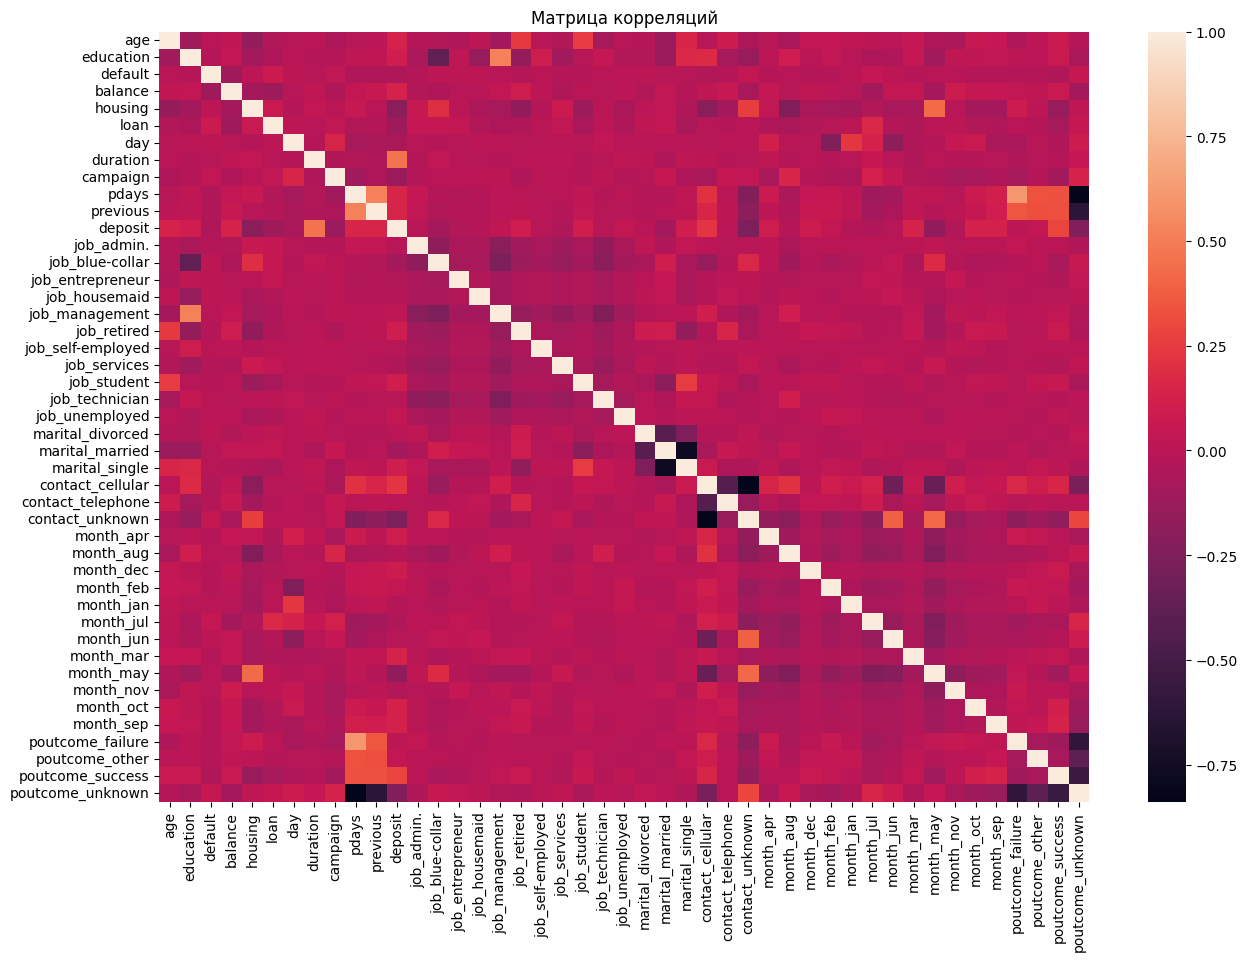

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr())
# заголовок графика
plt.title('Матрица корреляций')

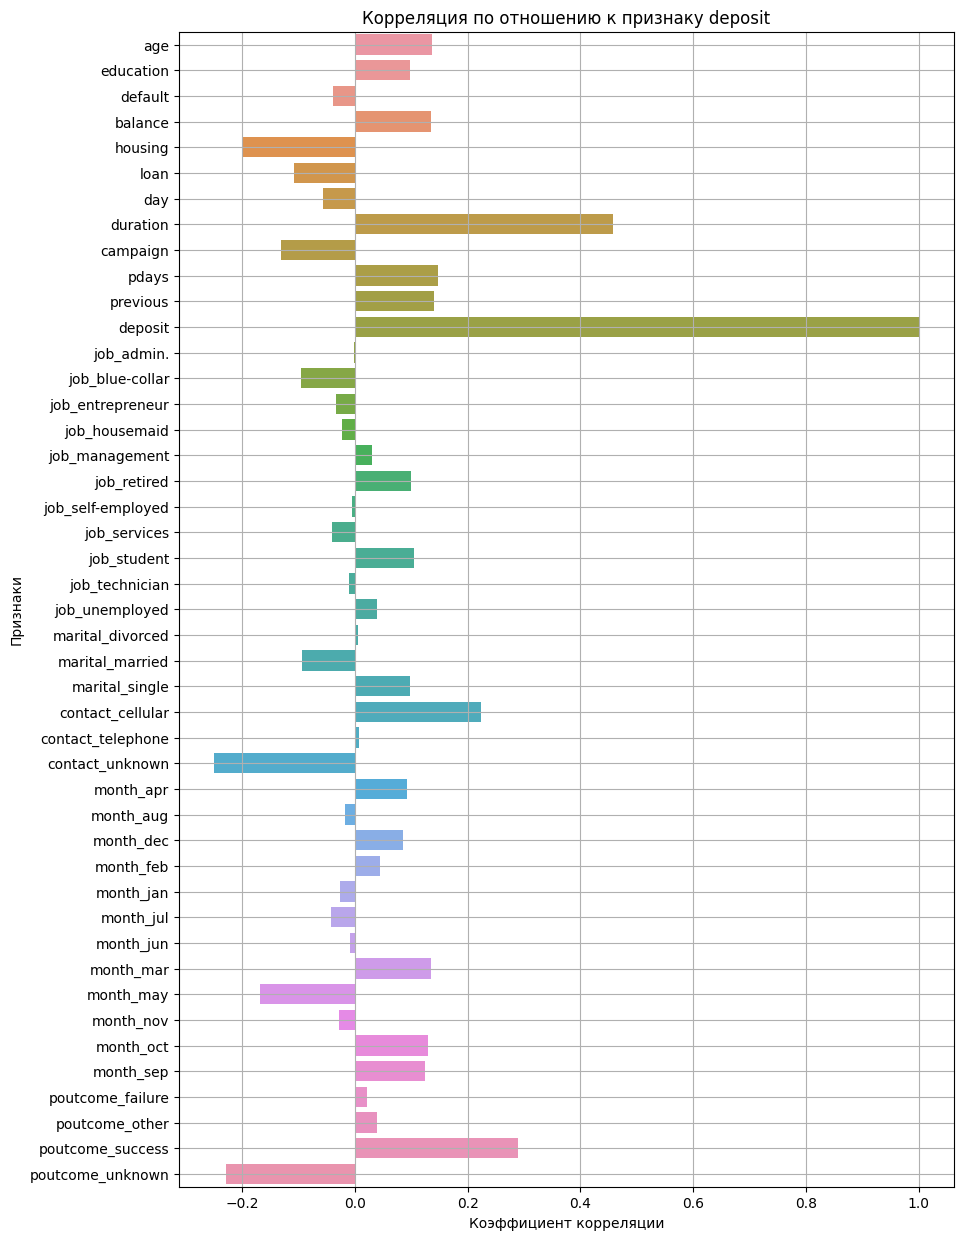

In [26]:
fig, ax = plt.subplots(figsize=(10, 15))
# строим столбчатую диаграмму корреляций по отношению к признаку deposit
sns.barplot(y=df.corr().deposit.index, x=df.corr().deposit.values, ax=ax) 
ax.grid() # сетка
ax.set_title('Корреляция по отношению к признаку deposit') # заголовок графика
ax.set_xlabel('Коэффициент корреляции') # подпись к оси x
ax.set_ylabel('Признаки'); # подпись к оси y

### Задания 7 и 8

In [27]:
# разделяем датасет на обучающие данные и целевой признак
X = df.select_dtypes(['int', 'float', 'uint8']).drop(['deposit'], axis=1)
y = df['deposit']
# разделяем данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(X_test.shape)
print(y_test.mean())

(3335, 44)
0.46326836581709147


### Задание 9

In [28]:
# отбираем 15 самых важных признаков
best_selector = feature_selection.SelectKBest(score_func=f_classif, k=15)
best_selector.fit(X_train, y_train)
# записываем полученные признаки в переменную
best_columns = best_selector.get_feature_names_out()
# оставляем в тестовом и тренировочном наборе данных только лучшие признаки
X_train_best = X_train[best_columns]
X_test_best = X_test[best_columns]
# выводим результат
df[best_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10105 non-null  int32  
 1   balance           10105 non-null  float64
 2   housing           10105 non-null  int64  
 3   duration          10105 non-null  int64  
 4   campaign          10105 non-null  int64  
 5   pdays             10105 non-null  int64  
 6   previous          10105 non-null  int64  
 7   contact_cellular  10105 non-null  uint8  
 8   contact_unknown   10105 non-null  uint8  
 9   month_mar         10105 non-null  uint8  
 10  month_may         10105 non-null  uint8  
 11  month_oct         10105 non-null  uint8  
 12  month_sep         10105 non-null  uint8  
 13  poutcome_success  10105 non-null  uint8  
 14  poutcome_unknown  10105 non-null  uint8  
dtypes: float64(1), int32(1), int64(5), uint8(8)
memory usage: 671.0 KB


### Задание 10

In [29]:
# нормализуем признаки методом MinMax
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_train_best)
# заменяем тренировочные и тестовые данные, нормализованными
X_train_scaled = minmax_scaler.transform(X_train_best)
X_test_scaled = minmax_scaler.transform(X_test_best)
X_test_scaled[:, 1:2].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [30]:
# задаём модель логистической регрессии
model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000) 
# обучаем модель на тренировочной выборке
model.fit(X_train_scaled, y_train)
# получаем результаты на тестовой выборке
test_pred = model.predict(X_test_scaled)
# выводим метрику accuracy
print('test accuracy:', metrics.accuracy_score(y_test, test_pred))

test accuracy: 0.8047976011994002


### Задания 2,3,4

In [31]:
# задаём модель дерева решений
model_tree = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
# обучаем модель на тренировочной выборке
model_tree.fit(X_train_scaled, y_train)
# получаем результаты на тренировочной и тестовой выборке
test_pred = model_tree.predict(X_test_scaled)
train_pred = model_tree.predict(X_train_scaled)
# выводим метрику accuracy
print('test accuracy:', metrics.accuracy_score(y_test, test_pred))
print('train accuracy:', metrics.accuracy_score(y_train, train_pred))

test accuracy: 0.808695652173913
train accuracy: 0.8186115214180206


### Задание 5

In [32]:
# задаём сетку параметров
params_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}
# совершаем перебор гиперпараметров для заданного ранее дерева решений
grid_search_tree = model_selection.GridSearchCV(estimator=model_tree, param_grid=params_grid, cv=5, n_jobs=-1)
grid_search_tree.fit(X_train_scaled, y_train)
# выводим наилучшие значения параметров
print('best params:', grid_search_tree.best_params_)
# получаем результаты на ранее созданной модели и лучшими значениями гиперпараметров
test_pred = grid_search_tree.predict(X_test_scaled)
# выводим метрику f1
print('test f1-score:', metrics.f1_score(y_test, test_pred))

best params: {'max_depth': 7, 'min_samples_split': 7}
test f1-score: 0.8062460165710643


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [38]:
# задаём модель случайного леса
forest = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
# обучаем модель на тренировочной выборке
forest.fit(X_train_scaled, y_train)
# получаем результаты на тренировочной и тестовой выборке
test_pred = forest.predict(X_test_scaled)
train_pred = forest.predict(X_train_scaled)
# выводим метрики
print('test metrics:\n', metrics.classification_report(y_test, test_pred))

test metrics:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [39]:
# задаём модель градиентного бустинга
boosting = ensemble.GradientBoostingClassifier(learning_rate=0.5, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
# обучаем модель на тренировочной выборке
boosting.fit(X_train_scaled, y_train)
# получаем результаты на тестовой выборке
test_pred = boosting.predict(X_test_scaled)
# выводим метрику f1
print('test f1-score:', metrics.f1_score(y_test, test_pred))

test f1-score: 0.783109404990403


### Задание 4

In [41]:
# задаём список моделей для последующего стекинга
estimators = [('dt', tree.DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_split=7)), 
              ('lr', linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)), 
              ('gb', ensemble.GradientBoostingClassifier(learning_rate=0.5, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))]
# выбираем параметры стекинга
stacking = ensemble.StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression())
# обучение модели
stacking.fit(X_train_scaled, y_train)
# получаем результаты на тестовой выборке
test_pred = stacking.predict(X_test_scaled)
# выводим метрики
print('test metrics:', metrics.classification_report(y_test, test_pred))

test metrics:               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [44]:
# производим отбор признаков методом рекурсивного исключения
selector = feature_selection.RFE(estimator=boosting, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
# выводим названия признаков
print(X_train_best.columns)
# выводим ранжирование
print(selector.ranking_)

Index(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 5,  1,  4,  1,  6,  3, 10, 12,  2,  7,  9,  8, 11,  1, 13])

### Задания 6,7,8

In [45]:
import optuna
# создаём функцию для подбора параметров
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    return score
study = optuna.create_study(study_name='first study', direction='maximize')
# производим подбор гиперпараметров
study.optimize(optuna_rf, n_trials=20)
# выводим лучшую конфигурацию гиперпараметров
print('best params:', study.best_params)

[I 2023-09-10 21:24:23,998] A new study created in memory with name: first study
[I 2023-09-10 21:24:24,612] Trial 0 finished with value: 0.9189782165804733 and parameters: {'n_estimators': 118, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9189782165804733.
[I 2023-09-10 21:24:25,245] Trial 1 finished with value: 0.8576790741319988 and parameters: {'n_estimators': 162, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9189782165804733.
[I 2023-09-10 21:24:26,061] Trial 2 finished with value: 0.8617403530698328 and parameters: {'n_estimators': 196, 'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9189782165804733.
[I 2023-09-10 21:24:26,869] Trial 3 finished with value: 0.8928738499922034 and parameters: {'n_estimators': 169, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9189782165804733.
[I 2023-09-10 21:24:27,362] Trial 4 finished with value: 0.8453705154316152 and parameters: {'n_estimators'

best params: {'n_estimators': 103, 'max_depth': 30, 'min_samples_leaf': 2}


In [47]:
# записываем лучшие параметры в переменную
best = study.best_params
# задаём модель случайного леса с подобранными параметрами
model = ensemble.RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']), min_samples_leaf=int(best['min_samples_leaf']), max_depth=int(best['max_depth']))
# обучаем модель
model.fit(X_train_scaled, y_train)
# получаем результаты
test_pred = model.predict(X_test_scaled)
# выводим метрики
print('test metrics:\n', metrics.classification_report(y_test, test_pred))

test metrics:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

